In [4]:
!pip install keras-tuner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import json
import kerastuner as kt

In [5]:
# Check for GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
with open("DeteksiSarkasme.json", 'r') as f:
     data = [json.loads(line) for line in f]
df = pd.DataFrame(data)

In [7]:
df = df[['headline', 'is_sarcastic']]

print("Label Distribution:\n", df['is_sarcastic'].value_counts())

Label Distribution:
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [8]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 29658


In [9]:
# Create sequences
X = tokenizer.texts_to_sequences(df['headline'])
X_padded = pad_sequences(X, maxlen=30, padding='post')
y = df['is_sarcastic'].values

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

In [11]:
# Model evaluation function
def evaluate_model(model, X_test, y_test):
    y_probs = model.predict(X_test)
    y_preds = (y_probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1_sq = f1_score(y_test, y_preds) ** 2
    auc = roc_auc_score(y_test, y_preds)

    print(f"Testing Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC: {auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return acc, precision, recall, f1_sq, auc

In [12]:
# Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
# 1. RNN Model
def create_rnn_model():
    model = Sequential([
        Embedding(vocab_size, 128, input_length=30),
        Bidirectional(SimpleRNN(256, return_sequences=False)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Calculate class weight to handle imbalance
    pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    class_weight = {0: 1.0, 1: pos_weight}

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    return model, class_weight

In [14]:
# 2. LSTM Model
def create_lstm_model():
    model = Sequential([
        Embedding(vocab_size, 128, input_length=30),
        Bidirectional(LSTM(128)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [15]:
# 3. GRU Model
def create_gru_model():
    model = Sequential([
        Embedding(vocab_size, 128, input_length=30),
        Bidirectional(GRU(128)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model


=== Training RNN Model ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6815 - loss: 0.6407

268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6818 - loss: 0.6403 - val_accuracy: 0.8379 - val_loss: 0.3712
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9070 - loss: 0.2735 - val_accuracy: 0.8432 - val_loss: 0.3794
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9575 - loss: 0.1345 - val_accuracy: 0.8313 - val_loss: 0.4724
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9771 - loss: 0.0811 - val_accuracy: 0.8056 - val_loss: 0.5885


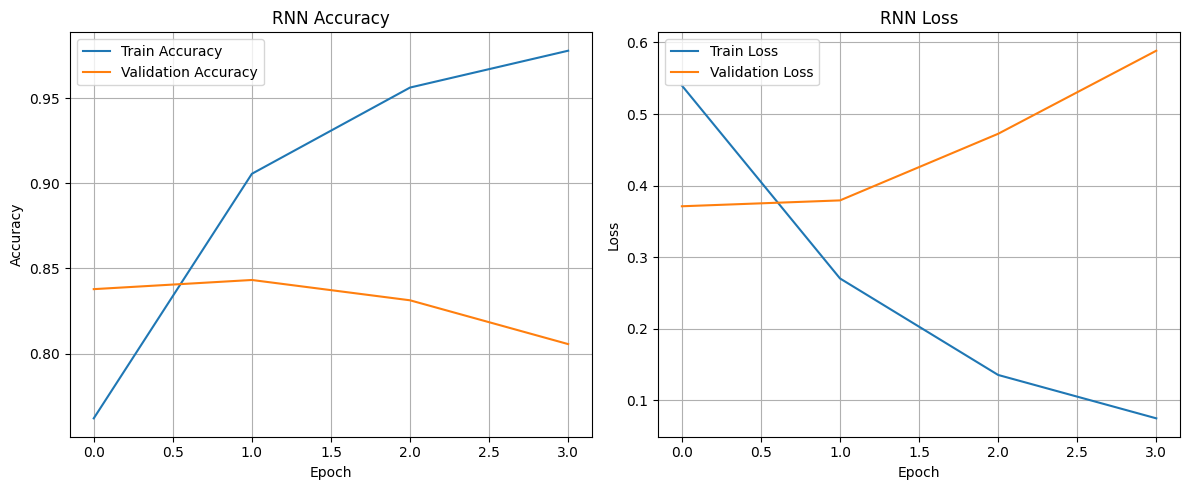


RNN Model Evaluation:
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing Accuracy: 0.8377
Precision: 0.8444
Recall: 0.7728
F1 Squared: 0.6513
AUC: 0.8307


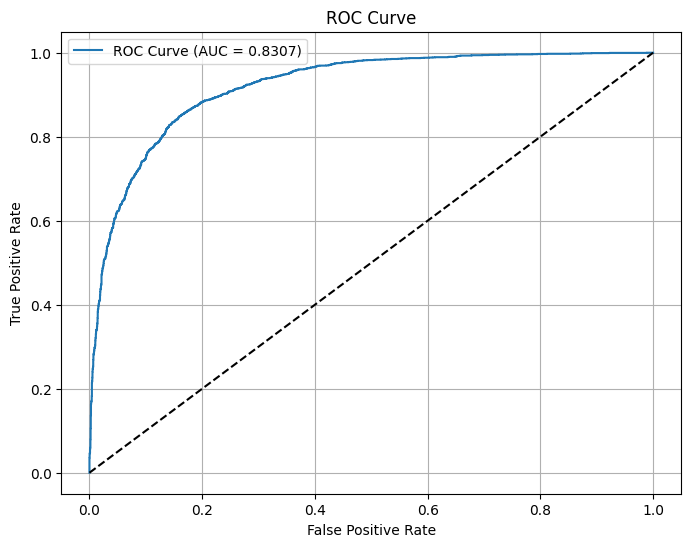

In [16]:
# Train and evaluate RNN
print("\n=== Training RNN Model ===")
rnn_model, class_weight = create_rnn_model()
rnn_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_rnn_model.h5', save_best_only=True)
]

rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight
)
plot_history(rnn_history, "RNN")
print("\nRNN Model Evaluation:")
rnn_metrics = evaluate_model(rnn_model, X_test, y_test)


=== Training LSTM Model ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7120 - loss: 0.5210

268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7123 - loss: 0.5206 - val_accuracy: 0.8638 - val_loss: 0.3250
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9199 - loss: 0.1987 - val_accuracy: 0.8573 - val_loss: 0.3580
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9655 - loss: 0.0977 - val_accuracy: 0.8486 - val_loss: 0.4359
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9843 - loss: 0.0461 - val_accuracy: 0.8439 - val_loss: 0.5048


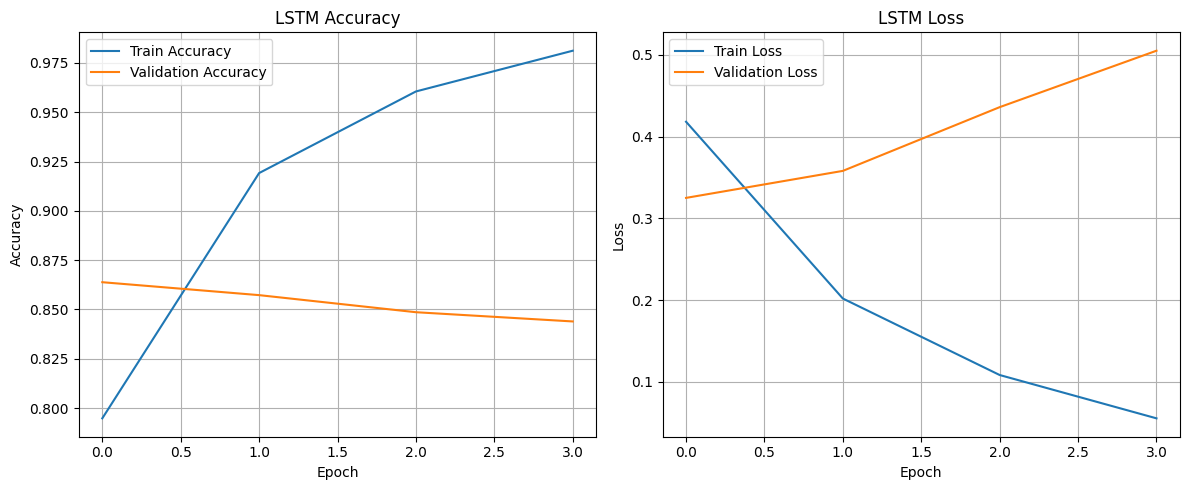


LSTM Model Evaluation:
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Testing Accuracy: 0.8549
Precision: 0.8151
Recall: 0.8662
F1 Squared: 0.7053
AUC: 0.8561


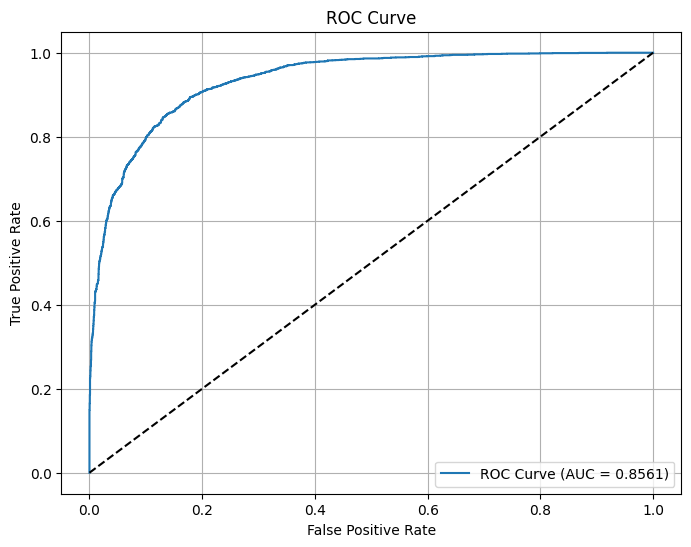

In [17]:
# Train and evaluate LSTM
print("\n=== Training LSTM Model ===")
lstm_model = create_lstm_model()
lstm_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
]

lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)
plot_history(lstm_history, "LSTM")
print("\nLSTM Model Evaluation:")
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)


=== Training GRU Model ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7117 - loss: 0.5221

268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7123 - loss: 0.5213 - val_accuracy: 0.8575 - val_loss: 0.3250
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9295 - loss: 0.1881 - val_accuracy: 0.8599 - val_loss: 0.3406
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9685 - loss: 0.0905 - val_accuracy: 0.8421 - val_loss: 0.4352
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9827 - loss: 0.0502 - val_accuracy: 0.8304 - val_loss: 0.5526


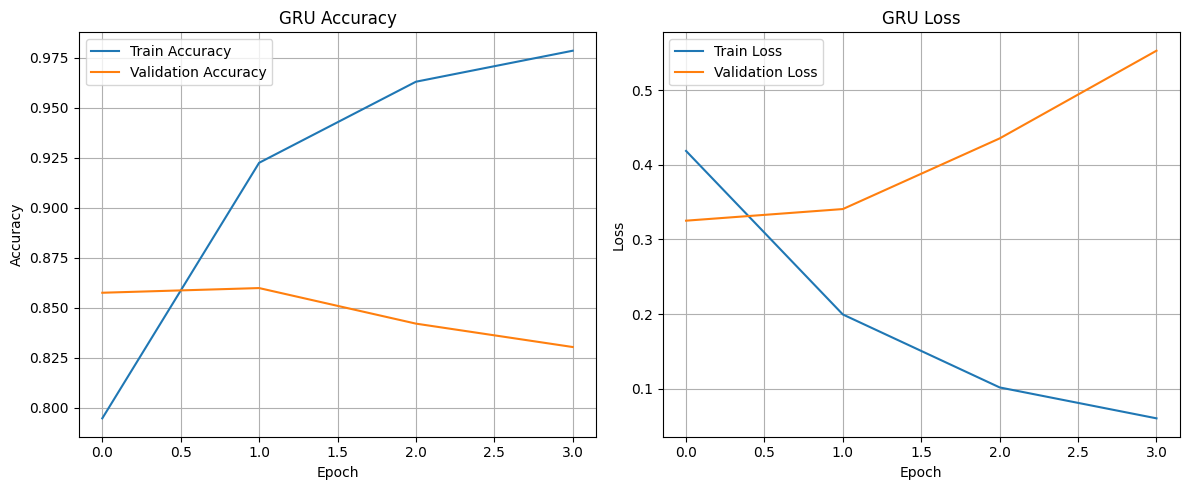


GRU Model Evaluation:
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Testing Accuracy: 0.8527
Precision: 0.8627
Recall: 0.7903
F1 Squared: 0.6805
AUC: 0.8459


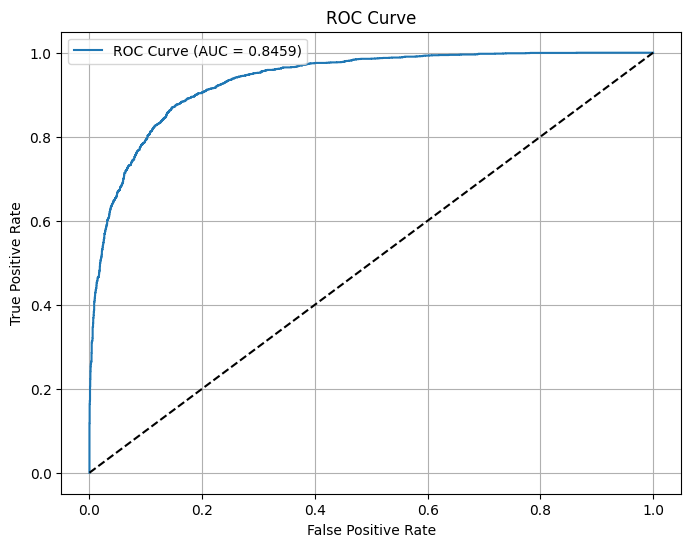

In [18]:
# Train and evaluate GRU
print("\n=== Training GRU Model ===")
gru_model = create_gru_model()
gru_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_gru_model.h5', save_best_only=True)
]

gru_history = gru_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)
plot_history(gru_history, "GRU")
print("\nGRU Model Evaluation:")
gru_metrics = evaluate_model(gru_model, X_test, y_test)

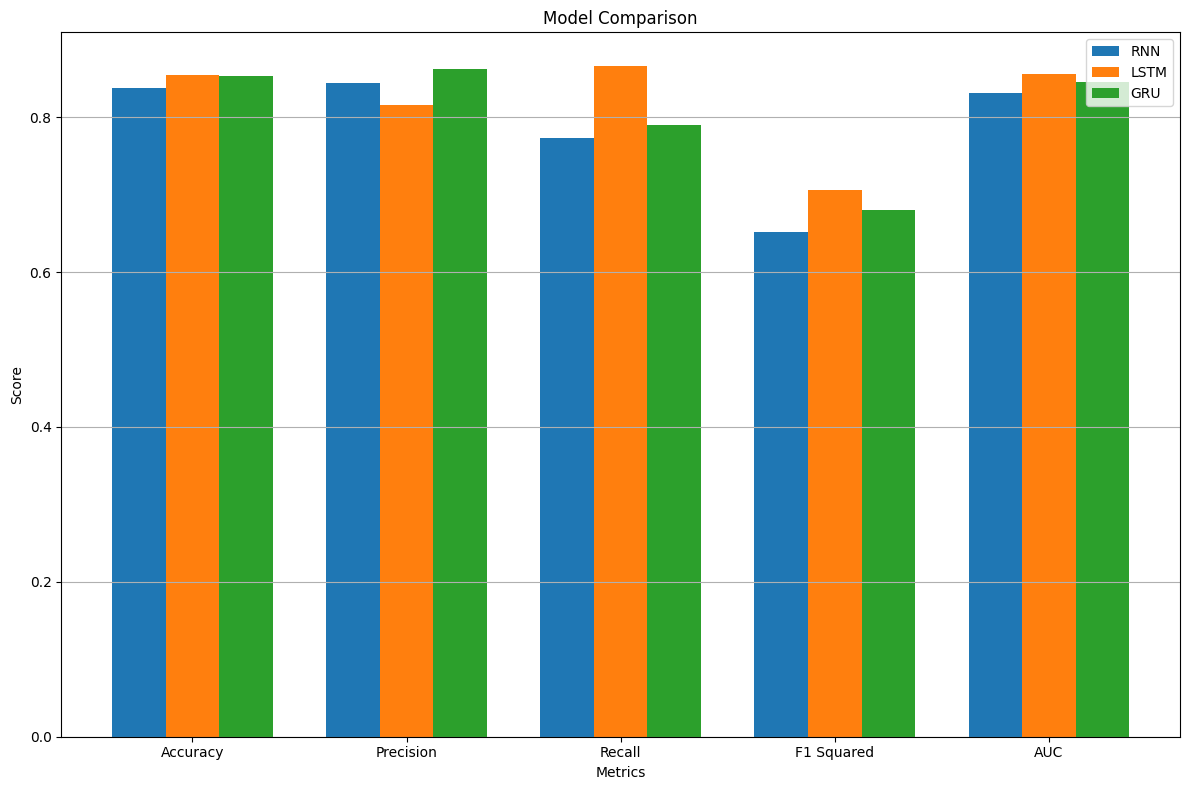

In [19]:
# Compare models
models = ['RNN', 'LSTM', 'GRU']
metrics = [rnn_metrics, lstm_metrics, gru_metrics]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Squared', 'AUC']

plt.figure(figsize=(12, 8))
x = np.arange(len(metric_names))
width = 0.25

for i, model_name in enumerate(models):
    plt.bar(x + i*width, metrics[i], width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x + width, metric_names)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
# Hyperparameter tuning with Keras Tuner
class SarcasmHyperModel(kt.HyperModel):
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size

    def build(self, hp):
        model_type = hp.Choice('model_type', ['lstm', 'gru', 'rnn'])
        embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
        units = hp.Int('units', min_value=64, max_value=256, step=64)
        learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001, 0.005])
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)

        model = Sequential()
        model.add(Embedding(self.vocab_size, embedding_dim, input_length=30))

        if model_type == 'lstm':
            model.add(Bidirectional(LSTM(units)))
        elif model_type == 'gru':
            model.add(Bidirectional(GRU(units)))
        else:  # rnn
            model.add(Bidirectional(SimpleRNN(units)))

        model.add(Dense(hp.Int('dense_units', 64, 256, 64), activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

In [21]:
print("\n=== Starting Hyperparameter Tuning ===")
hypermodel = SarcasmHyperModel(vocab_size)
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,  # In practice, use a larger number like 30
    directory='keras_tuner_dir',
    project_name='sarcasm_detection'
)

tuner.search(
    X_train, y_train,
    epochs=5,  # In practice, use more epochs
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2)]
)

print("\nBest hyperparameters:")
best_hps = tuner.get_best_hyperparameters(1)[0]
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 5 Complete [00h 00m 34s]
val_accuracy: 0.8357510566711426

Best val_accuracy So Far: 0.8617220520973206
Total elapsed time: 00h 02m 14s

Best hyperparameters:
model_type: gru
embedding_dim: 256
units: 192
learning_rate: 0.001
dropout_rate: 0.2
dense_units: 128


Epoch 1/10
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7336 - loss: 0.4970

268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7341 - loss: 0.4963 - val_accuracy: 0.8582 - val_loss: 0.3296
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9287 - loss: 0.1821 - val_accuracy: 0.8575 - val_loss: 0.3529
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9673 - loss: 0.0867 - val_accuracy: 0.8460 - val_loss: 0.4436
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9820 - loss: 0.0490 - val_accuracy: 0.8299 - val_loss: 0.6903


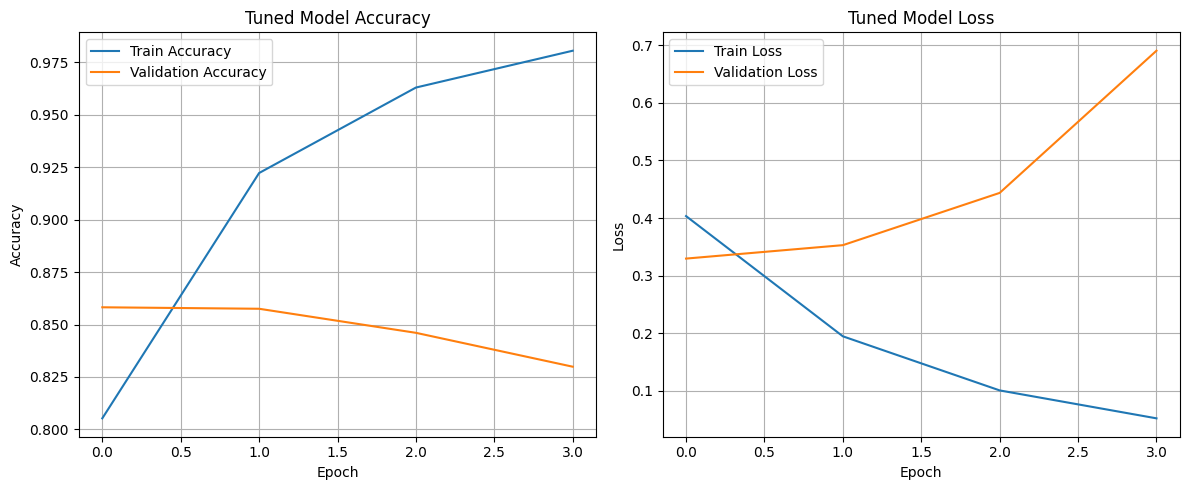


Tuned Model Evaluation:
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Testing Accuracy: 0.8540
Precision: 0.8566
Recall: 0.8018
F1 Squared: 0.6860
AUC: 0.8483


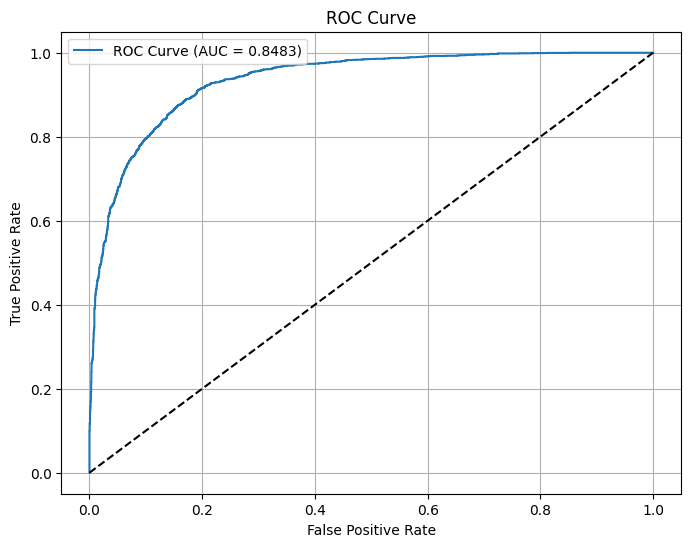

In [22]:
# Train the best model
best_model = tuner.hypermodel.build(best_hps)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_tuned_model.h5', save_best_only=True)
]

history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

plot_history(history, "Tuned Model")
print("\nTuned Model Evaluation:")
tuned_metrics = evaluate_model(best_model, X_test, y_test)

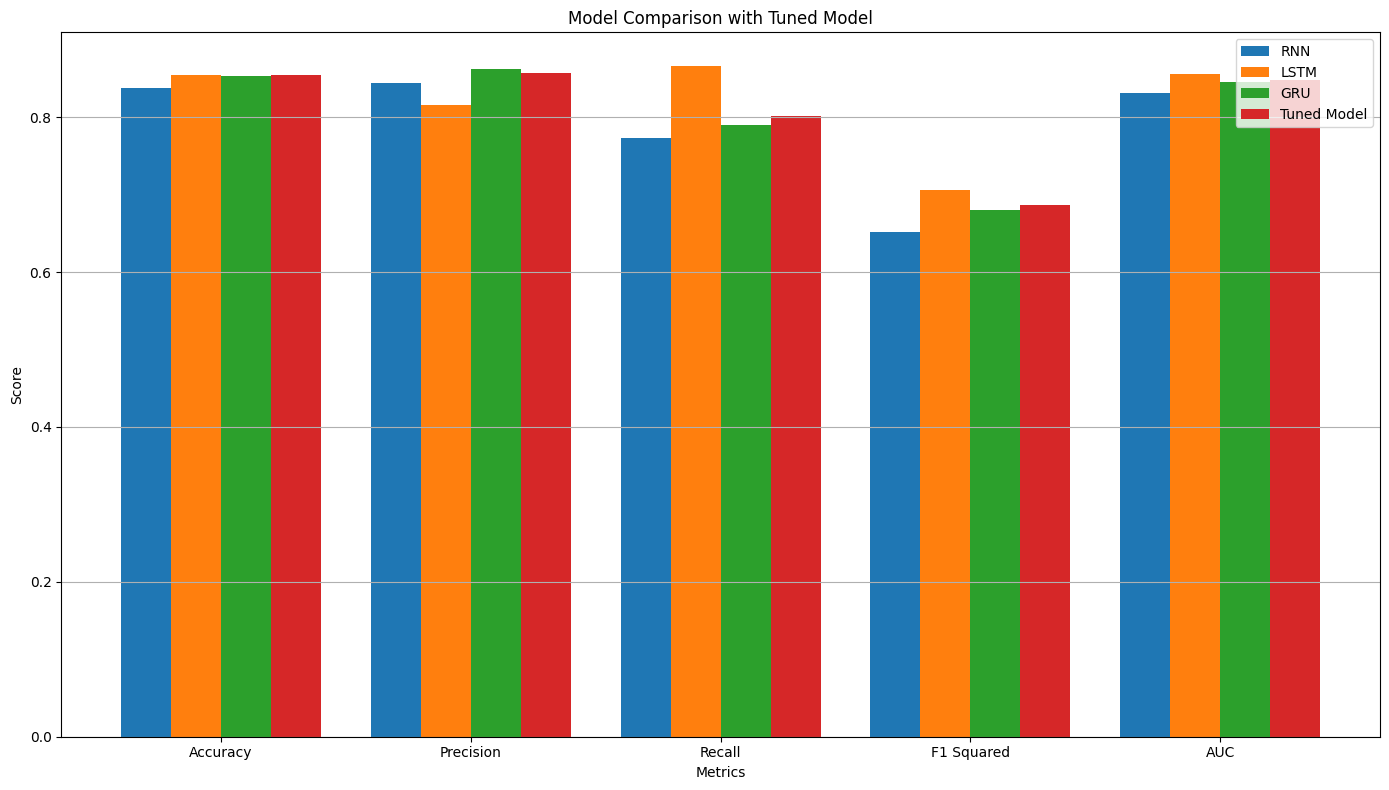

In [23]:
# Compare all models including tuned model
models = ['RNN', 'LSTM', 'GRU', 'Tuned Model']
metrics = [rnn_metrics, lstm_metrics, gru_metrics, tuned_metrics]

plt.figure(figsize=(14, 8))
x = np.arange(len(metric_names))
width = 0.2

for i, model_name in enumerate(models):
    plt.bar(x + i*width, metrics[i], width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison with Tuned Model')
plt.xticks(x + width*1.5, metric_names)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [24]:
# Function to test model with new headlines
def predict_sarcasm(headline, model, tokenizer):
    sequence = tokenizer.texts_to_sequences([headline])
    padded = pad_sequences(sequence, maxlen=30, padding='post')
    prediction = model.predict(padded)[0][0]
    return {
        'headline': headline,
        'probability': float(prediction),
        'prediction': 'Sarcastic' if prediction >= 0.5 else 'Not sarcastic'
    }

In [25]:
# Test with some example headlines
test_headlines = [
    "scientists discover new planet that could support life",
    "local man finally achieves dream of eating entire pizza alone",
    "new study shows coffee may extend lifespan",
    "area dad thinks he can fix national economy"
]

print("\n=== Testing with New Headlines ===")
for headline in test_headlines:
    result = predict_sarcasm(headline, best_model, tokenizer)
    print(f"Headline: {result['headline']}")
    print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f})")
    print()


=== Testing with New Headlines ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Headline: scientists discover new planet that could support life
Prediction: Sarcastic (Probability: 0.9189)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Headline: local man finally achieves dream of eating entire pizza alone
Prediction: Sarcastic (Probability: 1.0000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Headline: new study shows coffee may extend lifespan
Prediction: Sarcastic (Probability: 0.9111)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Headline: area dad thinks he can fix national economy
Prediction: Sarcastic (Probability: 0.9998)

